<a href="https://colab.research.google.com/github/Parsa132000/brain-decoding-ica-pca/blob/main/ica_vs_pca_brain_decoding_(0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 ICA vs PCA for Brain Decoding
This notebook compares Independent Component Analysis (ICA) and Principal Component Analysis (PCA) for cognitive state classification using fMRI data.

In [ ]:
!pip install nilearn nibabel scikit-learn matplotlib seaborn --quiet
import numpy as np
import pandas as pd
from nilearn.datasets import fetch_haxby
from nilearn.input_data import NiftiMasker
from nilearn.image import index_img
from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 33.5 MB/s eta 0:00:00


In [ ]:
# Load and preprocess Haxby dataset
haxby = fetch_haxby(data_dir='.')
labels = pd.read_csv(haxby.session_target[0], sep=' ')
condition_mask = labels['labels'] != 'rest'
labels_filtered = labels[condition_mask]
targets = labels_filtered['labels'].values
fmri_img = index_img(haxby.func[0], condition_mask)
masker = NiftiMasker(mask_img=haxby.mask_vt[0], standardize=True)
X = masker.fit_transform(fmri_img)
print(f"Shape of masked data: {X.shape}")

[_add_readme_to_default_data_locations] Added README.md to .

[get_dataset_dir] Dataset created in haxby2001

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7868/mask.nii.gz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from http://data.pymvpa.org/datasets/haxby2001/MD5SUMS ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from http://data.pymvpa.org/datasets/haxby2001/subj2-2010.01.14.tar.gz ...

[_chunk_report_] Downloaded 102498304 of 291168628 bytes (35.2%%,    1.8s remaining)

[_chunk_report_] Downloaded 250339328 of 291168628 bytes (86.0%%,    0.3s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from haxby2001/9cabe068089e791ef0c5fe930fc20e30/subj2-2010.01.14.tar.gz...

[uncompress_file] .. done.

/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:489: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Shape of masked data: (864, 464)


In [ ]:
# Apply PCA and ICA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

ica = FastICA(n_components=100, random_state=42)
X_ica = ica.fit_transform(X)

print(f"PCA shape: {X_pca.shape}, ICA shape: {X_ica.shape}")

PCA shape: (864, 100), ICA shape: (864, 100)


In [ ]:
# Encode labels, Train Classifier and Evaluate ICA vs PCA
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(targets)

# Train-test split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)
X_train_ica, X_test_ica, _, _ = train_test_split(X_ica, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Train SVM classifiers
clf_pca = SVC(kernel='linear')
clf_ica = SVC(kernel='linear')
clf_pca.fit(X_train_pca, y_train)
clf_ica.fit(X_train_ica, y_train)

# Predict
y_pred_pca = clf_pca.predict(X_test_pca)
y_pred_ica = clf_ica.predict(X_test_ica)

In [ ]:
# Classification reports
print("PCA Classification Report")
print(classification_report(y_test, y_pred_pca, target_names=le.classes_))

print("ICA Classification Report")
print(classification_report(y_test, y_pred_ica, target_names=le.classes_))

PCA Classification Report
              precision    recall  f1-score   support

      bottle       0.68      0.90      0.78        21
         cat       0.83      0.79      0.81        19
       chair       0.82      0.90      0.86        20
        face       0.89      0.80      0.84        20
       house       1.00      0.93      0.97        15
    scissors       0.96      0.73      0.83        30
scrambledpix       0.96      1.00      0.98        22
        shoe       0.85      0.88      0.87        26

    accuracy                           0.86       173
   macro avg       0.87      0.87      0.87       173
weighted avg       0.87      0.86      0.86       173

ICA Classification Report
              precision    recall  f1-score   support

      bottle       0.63      0.81      0.71        21
         cat       0.78      0.74      0.76        19
       chair       0.82      0.70      0.76        20
        face       0.82      0.70      0.76        20
       house       1.00   

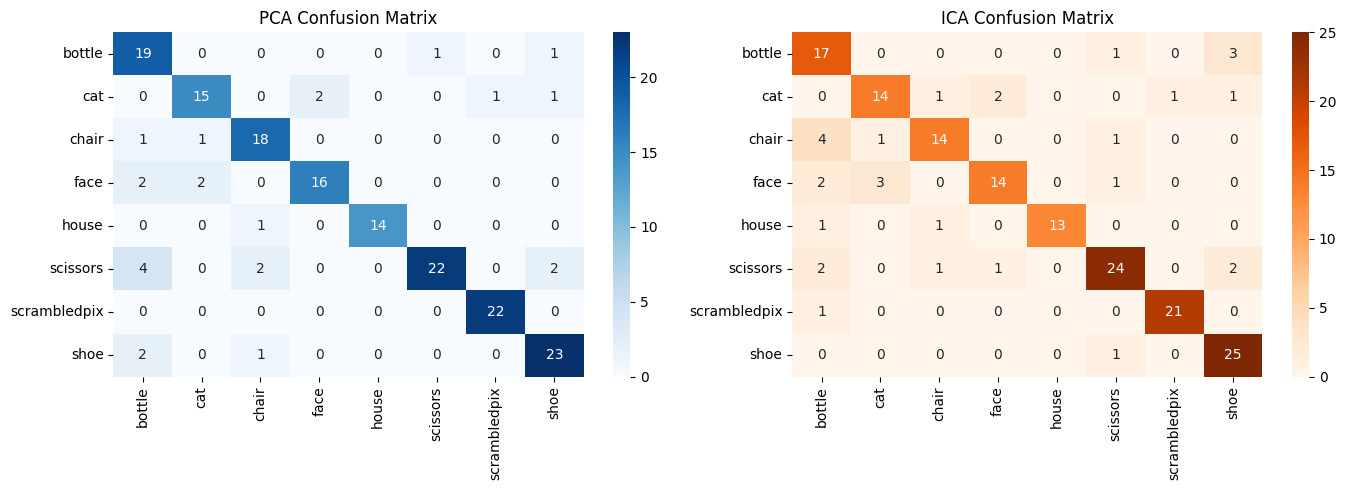

In [ ]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_pca), annot=True, fmt='d', ax=axes[0], cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title("PCA Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, y_pred_ica), annot=True, fmt='d', ax=axes[1], cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title("ICA Confusion Matrix")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/nilearn/plotting/displays/_slicers.py:313: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


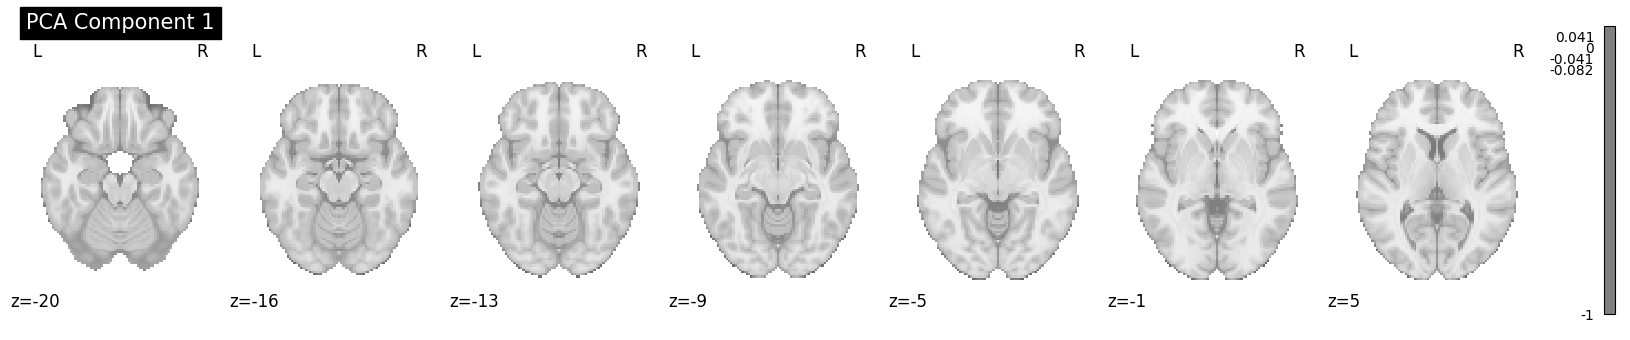

In [ ]:
# Visualize the first PCA and ICA components
from nilearn.plotting import plot_stat_map

# PCA component
component_img_pca = masker.inverse_transform(pca.components_[0])
plot_stat_map(component_img_pca, title='PCA Component 1', display_mode='z', cut_coords=7, threshold=1.0)

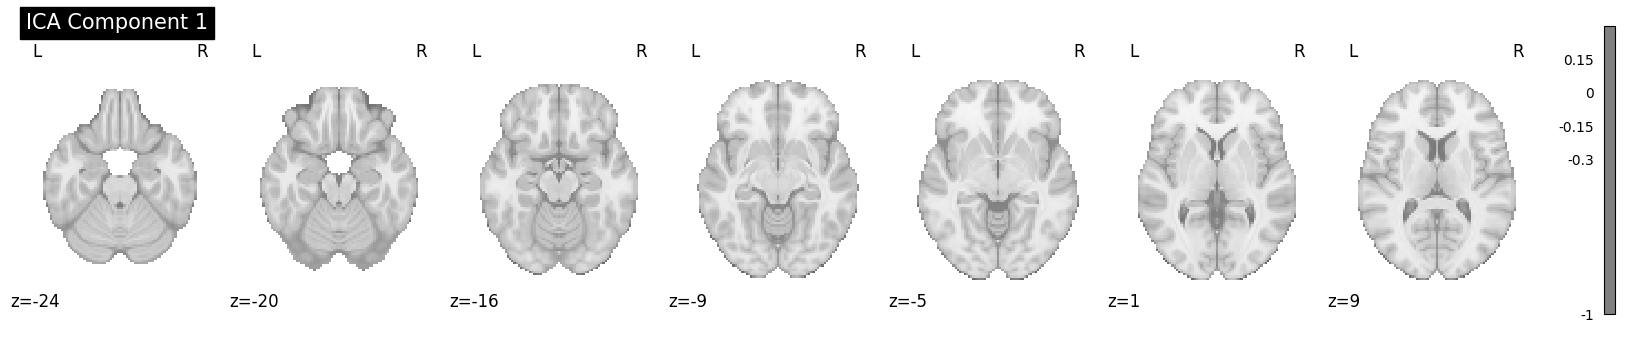

In [ ]:
# ICA component
component_img_ica = masker.inverse_transform(ica.components_[0])
plot_stat_map(component_img_ica, title='ICA Component 1', display_mode='z', cut_coords=7, threshold=1.0)